## Detector model: Kiukas / Ruschhaupt / Schmidt / Werner

In [46]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [47]:
init_printing ()

In [48]:
gamma = Symbol('gamma', real=True, positive=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [49]:
GAMMA = Rational(1, 1000)

In [50]:
def D(_gamma):
    return Rational(1, 2) * Matrix([
        [0, 0],
        [0, _gamma]
    ])

In [51]:
H = Matrix ([
[0, 1] ,
[1, 0]
])

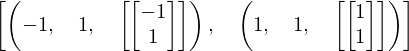

In [52]:
H.eigenvects()

It's manually seen that $\langle H \rangle = 0$ and $\langle H^2 \rangle = 1$, therefore $\sigma_{H} = 1$.

In [53]:
def K(_gamma):
    return H - I*D(_gamma)

In [54]:
def B(_gamma):
    return lambda t: exp(-I*K(_gamma)*t)

In [55]:
def U():
    return lambda t: exp(-I*H*t)

In [56]:
def non_unitary_psi(_t, _gamma=GAMMA):
    return B(_gamma)(_t) * Matrix([1,0])

In [57]:
def unitary_psi(_t):
    return U()(_t) * Matrix([1,0])

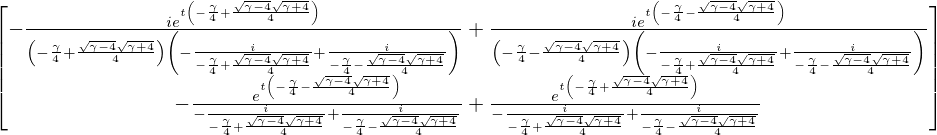

In [58]:
non_unitary_psi(t, gamma)

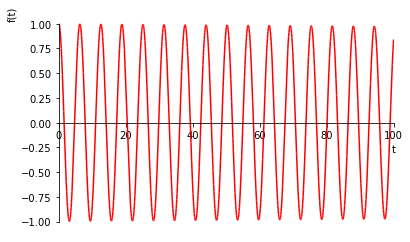

In [59]:
plot(re(non_unitary_psi(t)[0]), (t, 0, 100), line_color='r')

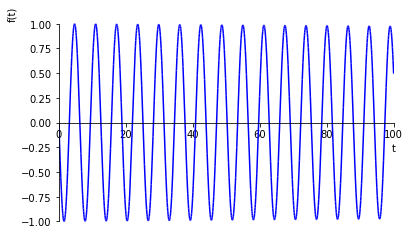

In [60]:
plot(im(non_unitary_psi(t)[1]), (t, 0, 100), line_color='b')

In [61]:
def lossy_norm(_t, _gamma=GAMMA):
    psi = B(_gamma)(_t) * Matrix([1,0])
    return abs(psi[0])**2 + abs(psi[1])**2

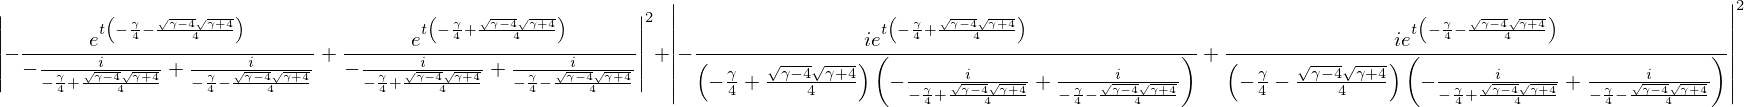

In [62]:
lossy_norm(t, gamma)

In [63]:
non_unitary_psi_n = lambdify(t, non_unitary_psi(t), "numpy")

In [64]:
_lossy_norm_n = lambdify(t, lossy_norm(t), "numpy")
def lossy_norm_n(__t):
    # prevent a warning, even if we know it's real
    return np.real(_lossy_norm_n(__t))

In [65]:
def non_unitary_psi_renorm_n(_t):
    return non_unitary_psi_n(_t) / np.sqrt(lossy_norm_n(_t))

In [66]:
T = np.linspace(1e-16, 100, 2000)

Text(0.5, 0, 't')

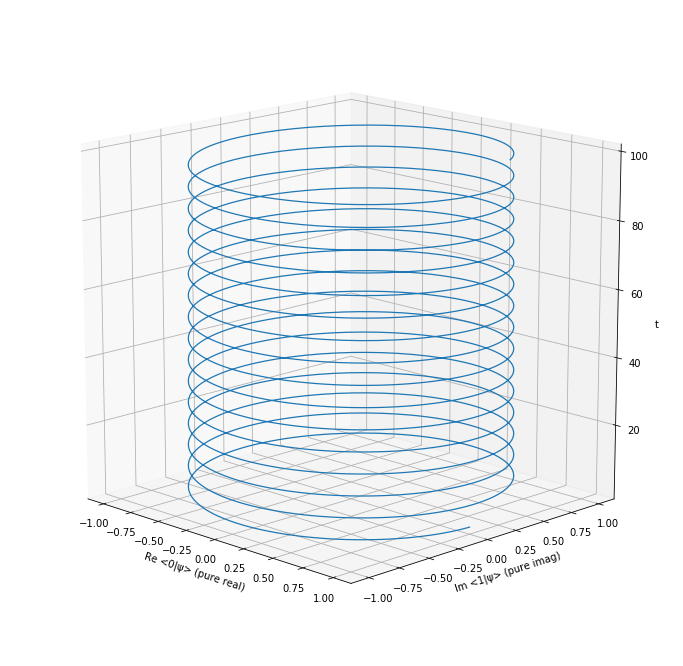

In [67]:
fig = plt.figure(figsize=(12,12))

ax = fig.gca(projection='3d')
ax.view_init(15,-45) # rotate 3d point of view

ax.plot(
    np.real(non_unitary_psi_n(T)[0][0]), np.imag(non_unitary_psi_n(T)[1][0]), T,
    linewidth=1.25
)

##ax.legend()

plt.xlabel('Re <0|\u03C8> (pure real)')
plt.ylabel('Im <1|\u03C8> (pure imag)')
ax.set_zlabel('t')


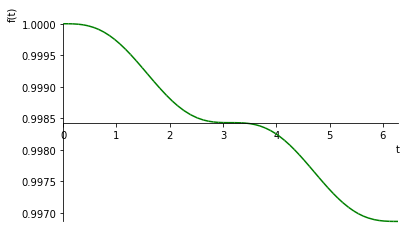

In [68]:
plot(lossy_norm(t),(t, 0, 2*pi), line_color='g')

In [69]:
def prob_0_unitary(t):
    return abs(unitary_psi(t)[0]**2)

In [70]:
def prob_1_unitary(t):
    return abs(unitary_psi(t)[1]**2)

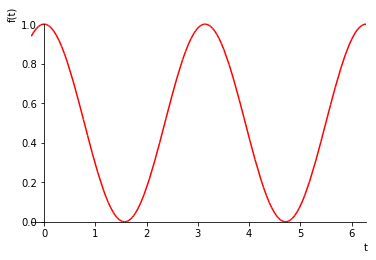

In [71]:
plot(prob_0_unitary(t),(t, -0.25, 2*pi), line_color='r')

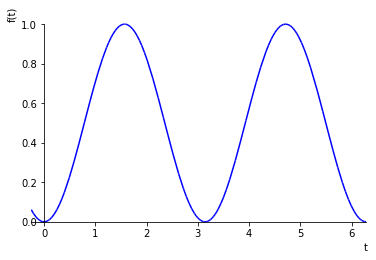

In [72]:
plot(prob_1_unitary(t),(t, -0.25, 2*pi), line_color='b')

In [73]:
X = np.linspace(1e-6, 2*np.pi, 1000)  # avoid singularity in t=0

In [74]:
Y = lossy_norm_n(X)

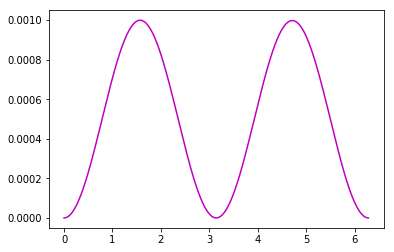

In [75]:
plt.plot(X, -np.gradient(Y, X), 'm')

In [76]:
# we have set gamma = 2*sqrt(2)
def hatpsi(_t, _gamma=GAMMA):
    return \
        Heaviside(_t) * \
        Matrix([
            [0, 0],
            [0, sqrt(_gamma)]
        ]) * \
        non_unitary_psi(_t, _gamma)
        
def hatpsi_n(_t):
    return \
        np.heaviside(_t, 0) * \
        2**(3/4) * \
        np.array([
            [0, 0],
            [0, 1]
        ]) * \
        non_unitary_psi_n(_t)
        
        
    

In [77]:
def hatpsisquarednorm(_t, _gamma=GAMMA):
    return simplify(
        abs(hatpsi(_t, _gamma)[0])**sympify(2) + abs(hatpsi(_t, _gamma)[1])**sympify(2)
    )

def hatpsisquarednorm_n(_t):
    return abs(hatpsi_n(_t)[0]**2) + abs(hatpsi_n(_t)[1]**2)

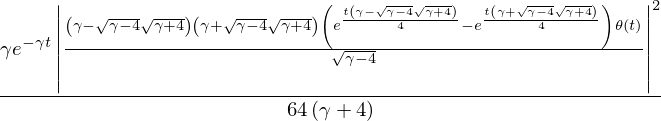

In [78]:
hatpsisquarednorm(t, _gamma=gamma)

In [79]:
# this is not conceptually correct... just out of curiosity for now...
# prob over time Vs prob over "space" i.e. being |0> or |1> ...
p = plot(
    hatpsisquarednorm(t, 0.01)*100, prob_1_unitary(t),
    (t, -2, 20*pi),
    show=False
)

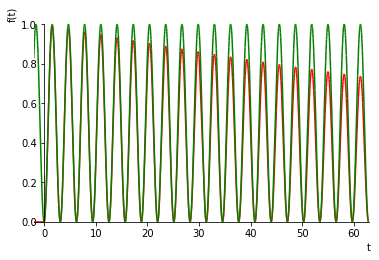

In [80]:
p[0].line_color = 'red'
p[1].line_color = 'green'
p.show()

In [81]:
def prob_0_hatpsi(_t):
    return abs(hatpsi(_t)[0]**2) / (abs(hatpsi(_t)[0]**2) + abs(hatpsi(_t)[1]**2))

In [82]:
def prob_1_hatpsi(_t):
    return abs(hatpsi(_t)[1]**2) / (abs(hatpsi(_t)[0]**2) + abs(hatpsi(_t)[1]**2))

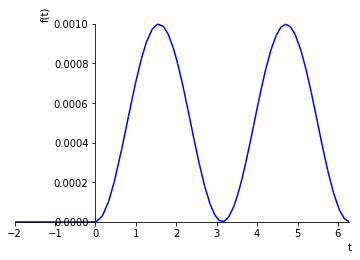

In [83]:
plot( abs(hatpsi(t)[1]**2), (t, -2, 2*pi), line_color='b')

In [84]:

# TODO: switch to numeric and use FFT 
# https://docs.scipy.org/doc/numpy-1.15.0/reference/routines.fft.html#real-and-hermitian-transforms
# The below takes ages to complete


#def fhatpsi1(_nu):
#    return fourier_transform(hatpsi(t)[1], t, _nu)

In [85]:
#plot(abs(fhatpsi1(nu))**2, (nu, -1, 1), line_color='#bbbbbb')

> The above Fourier transform is defined in frequency (\nu) not angular frequency (\omega),
therefore needs rescaling.

In [86]:
#def fhatpsiomega(_omega):
#    return fhatpsi1(_omega/(2*pi)) / sqrt((2*pi))

In [87]:
#plot(abs(fhatpsiomega(omega))**2, (omega, -2*pi, 2*pi), line_color='magenta')

In [88]:
# graphical comparison with a normalized gaussian
#sigma = 1.0
#plot((1/(sqrt(2*pi)*sigma)) * exp(-omega**2/(2*(sigma)**2)), (omega, -2*pi, 2*pi), line_color='magenta')

## (Discrete) Page-Wootters model

In [89]:
from scipy.linalg import dft, norm, expm
from scipy import stats

In [90]:
T = np.diag(np.arange(0,32)) * np.pi / 16

In [91]:
# The NumPy Fourier matrix is the conjugate of Mathematica's one,
# hence the trailing .conj() 
F = dft(32, scale='sqrtn').conj()

In [92]:
F_dagger = F.conj().T

In [93]:
Omega = F @ T @ F_dagger * 16 / np.pi

In [94]:
oeigenvalues, oeigenvectors = np.linalg.eig(Omega)

In [95]:
np.round(oeigenvalues)

array([-0.-0.j, 31.-0.j,  1.-0.j, 30.+0.j,  2.+0.j, 29.+0.j,  3.+0.j,
       28.-0.j,  4.+0.j, 27.+0.j,  5.-0.j, 26.-0.j,  6.-0.j, 25.-0.j,
        7.+0.j,  8.-0.j, 24.+0.j,  9.-0.j, 23.-0.j, 10.-0.j, 22.-0.j,
       11.-0.j, 21.-0.j, 12.-0.j, 13.-0.j, 20.-0.j, 14.-0.j, 15.-0.j,
       19.-0.j, 16.+0.j, 17.-0.j, 18.-0.j])

In [96]:
H = np.array([
    [0, 1],
    [1, 0]
])

In [97]:
#D = np.array([
#    [0, 0],
#    [0, np.sqrt(2)]
#])

In [98]:
#K = H - 1j*D

In [99]:
#K

In [100]:
J = np.kron(Omega, np.eye(2)) + np.kron(np.eye(32), H)

In [101]:
eigenvalues, eigenvectors = np.linalg.eig(J)

In [102]:
EnergyCorrectionMatrices = np.zeros((64, 64, 64), np.complex)
for n in range(64):
    EnergyCorrectionMatrices[n] = np.kron(
        expm(-1j*eigenvalues[n]*T),
        np.eye(2)
    )
# TODO: DRY
EnergyCorrectionMatricesT = np.zeros((64, 32, 32), np.complex)
for n in range(64):
    EnergyCorrectionMatricesT[n] = expm(-1j*eigenvalues[n]*T)


In [103]:
def history_vector(eigenindex):
    # Needs matrix transposition ".T" (different convention as opposed to Mathematica)
    eigenvector = eigenvectors.T[eigenindex]
    return EnergyCorrectionMatrices[eigenindex] @ eigenvector

# "unflatten" the history_vector v into a a sequence of qubit component pairs
def reshape(v):
    return np.reshape(v, (-1,2))

# also make the first component real
def normalize_initial(v):
    vout = np.zeros(64, np.complex)
    # A phase factor to make it real
    vout = v * np.exp(-1j * np.angle(v[0]))
    # And a factor to normalize the initial state
    vout = vout / sqrt(
        np.abs(vout[0]**2) + np.abs(vout[1]**2)
    )
    return vout

In [104]:
# Find the best linear combination to obtain |0> as initial state
def find_best():
    max_prob0 = 0
    max_prob0_i = 0
    max_prob0_j = 0
    for i in range(32):
        for j in range(32):
            qbi = reshape(history_vector(i))
            qbj = reshape(history_vector(j))
            qbit_hist = qbi + qbj
            prob0 = np.abs(qbit_hist[0][0]**2) / (
                np.abs(qbit_hist[0][0]**2) + np.abs(qbit_hist[0][1]**2)
            )
            if prob0 > max_prob0:
                max_prob0 = prob0
                max_prob0_i = i
                max_prob0_j = j
    print (max_prob0_i, max_prob0_j, max_prob0)
    return (max_prob0_i, max_prob0_j)
    

In [105]:
# start with |0> as close as possible
i, j = find_best()
qbhistvec = normalize_initial(history_vector(i) + history_vector(j))
qbhist = reshape(qbhistvec) 

4 4 1.0


In [106]:
qbhist = qbhist.astype(complex)

Consitently with "odinary QM" findings, the component along |0> stays purely real, and the component along |1> stays purely imaginary.

In [107]:
# Fill data for plotting
times = np.arange(0, 2*np.pi, np.pi/16)
norms = np.zeros(32)
probs0 = np.zeros(32)
probs1 = np.zeros(32)
# Components 0 are pure real, componets 1 are pure imag
real_parts0 = np.real(qbhist.T[0])
imag_parts0 = np.imag(qbhist.T[0])
real_parts1 = np.real(qbhist.T[1])
imag_parts1 = np.imag(qbhist.T[1])

for i in range(0, 32):
    norms[i] = (np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2))
    probs0[i] = np.abs(qbhist[i][0]**2) / (
        np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2) )
    probs1[i] = np.abs(qbhist[i][1]**2) / (
        np.abs(qbhist[i][0]**2) + np.abs(qbhist[i][1]**2) )

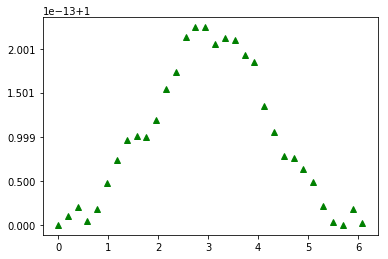

In [108]:
plt.plot(times, norms/norms[0], 'g^')

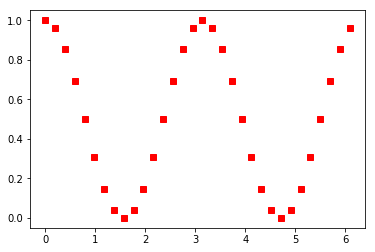

In [109]:
plt.plot(times, probs0, 'rs')

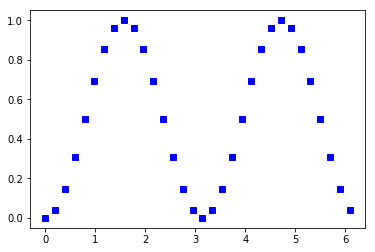

In [110]:
plt.plot(times, probs1, 'bs')

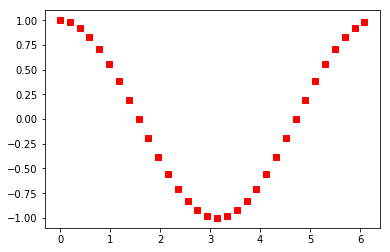

In [111]:
plt.plot(times, real_parts0, 'rs')

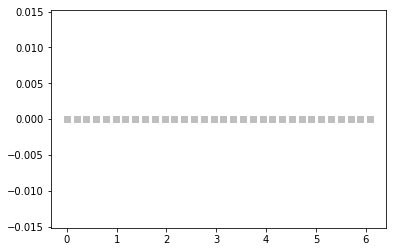

In [112]:
plt.scatter(times, imag_parts0, color='0.75', marker='s')

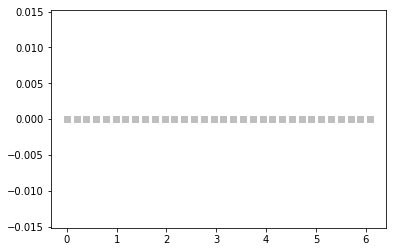

In [113]:
plt.scatter(times, real_parts1, color='0.75', marker='s')

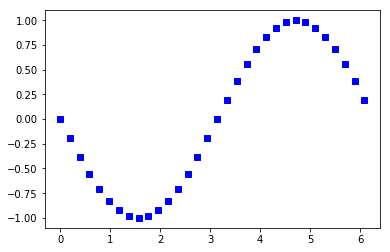

In [114]:
plt.plot(times, imag_parts1, 'bs')

## TOA prob as in Maccone/Sacha arXiv:1810.12869
_Adapted from $\S$ "Time of arbitrary event"._

\begin{equation}
    p(t|1) = \frac{\left|\psi(1|t)\right|^2}{\int_0^\mathcal{T} dt \left|\psi(1|t)\right|^2} = 
    \frac{
        \left| {}_{T}\langle n | \otimes {}_{S}\langle 1 | \Psi \rangle\rangle \right|^2
    }{
        %\frac{\mathcal{T}}{N}
        \sum_{n'=0}^{N-1} \left| {}_{T}\langle n' | \otimes {}_{S}\langle 1 | \Psi \rangle\rangle \right|^2
    }
\end{equation}

Where:

* $\psi(1|t) = \langle 1 | \psi(t) \rangle = {}_{T}\langle n | \otimes {}_{S}\langle 1 | \Psi \rangle\rangle$
* $t = \frac{2\pi}{N} n$ and ${}_{T}\langle n |$ is the corresponding time eigenstate.
* We fix period $\mathcal{T}=2\pi$
    i.e. period of a Rabi oscillation for $H = \hbar\omega\begin{pmatrix}0&1\\1&0\end{pmatrix}$
    and $\hbar = \omega = 1$.

In [115]:
qbhistvec =  qbhistvec.astype(complex)
qbhistvec_normalized = qbhistvec / np.linalg.norm(qbhistvec)

In [116]:
qbhistvec_normalized

array([ 1.76776695e-01-1.40407472e-17j,  4.40725430e-15-2.17964348e-15j,
        1.73379981e-01-3.72013579e-15j,  3.74414419e-15-3.44874224e-02j,
        1.63320371e-01-8.21141890e-15j,  1.27705636e-15-6.76495125e-02j,
        1.46984450e-01-1.22765370e-14j, -2.45445055e-15-9.82118698e-02j,
        1.25000000e-01-1.35160007e-14j, -6.66589187e-15-1.25000000e-01j,
        9.82118698e-02-1.31611638e-14j, -1.15687698e-14-1.46984450e-01j,
        6.76495125e-02-1.19970477e-14j, -1.77593369e-14-1.63320371e-01j,
        3.44874224e-02-8.61402586e-15j, -2.42176284e-14-1.73379981e-01j,
       -5.07289893e-15-4.09173967e-15j, -3.01654765e-14-1.76776695e-01j,
       -3.44874224e-02+2.01340303e-15j, -3.42512690e-14-1.73379981e-01j,
       -6.76495125e-02+9.63782375e-15j, -3.65498616e-14-1.63320371e-01j,
       -9.82118698e-02+1.92257571e-14j, -3.84431059e-14-1.46984450e-01j,
       -1.25000000e-01+2.80353437e-14j, -3.58883273e-14-1.25000000e-01j,
       -1.46984450e-01+3.98031291e-14j, -3.35129397

In [117]:
def t_eigenstate(n):
    v = np.zeros(32, dtype=np.complex)
    v[n] = 1
    return v

In [118]:
t_eigenstate(n=2)

array([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [119]:
qubit1 = np.array([0, 1])

In [120]:
def tn_ox_1(n):
    return np.kron(t_eigenstate(n), qubit1)

In [121]:
def joint_prob(n):
    return np.abs(tn_ox_1(n) @ qbhistvec_normalized)**2

In [122]:
X = np.arange(32)
iterable = (joint_prob(n) for n in X)
Y = np.fromiter(iterable, float)


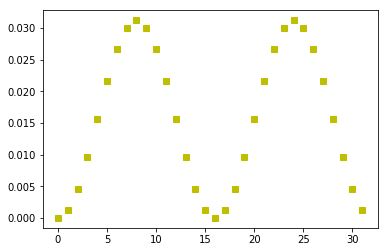

In [123]:
plt.plot(X, Y, 'ys')